<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Tutorial_8_Class_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

In [4]:
'''
transforms.ToTensor()- is one of the transformations provided by PyTorch.
                       It converts a PIL Image or numpy array into a PyTorch tensor.
'''
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Use smaller dataset for faster processing
# indices = [i for i, (img, label) in enumerate(train_dataset) if label in [0, 1]]
# filtered_train_dataset = torch.utils.data.Subset(train_dataset, indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15958187.97it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266643.01it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4949299.94it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6155153.08it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [15]:
# Define the CNN
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1,16,kernel_size = 3,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2),
        nn.Conv2d(16,32,kernel_size = 3,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU()
    )
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.classifier = nn.Linear(64,10)
    self.act = nn.Softmax(dim = 1)

  def forward(self,x):
    x = self.features(x)
    self.feature_maps = x
    x = self.avgpool(x)
    # This line flattens the tensor into a 1D tensor, where the first dimension
    # represents the batch size (x.size(0)) and the second dimension represents
    # the flattened feature vector.
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    x = self.act(x)
    return x

In [16]:
# Function to plot CAM
def plot_cam(model, img, label, target):
    model.eval()
    with torch.no_grad():
        output = model(img.unsqueeze(0))
    _, pred = torch.max(output, 1)
    pred = pred.item()
    class_activation = model.feature_maps.squeeze().detach()

    # Get the weights for the correct class
    weight_softmax_params = list(model.classifier.parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())[target]

    # Create the class activation map.
    cam = weight_softmax.dot(class_activation.reshape((64, 49))).reshape(7, 7)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    # Resize CAM to 28x28 (the same size as the input images)
    cam_img = Image.fromarray(cam_img).resize((28, 28), Image.BILINEAR)

    plt.imshow(cam_img, cmap='jet', alpha=0.5)
    plt.imshow(img.squeeze(), alpha=0.5)
    plt.title(f'Predicted: {pred}, Actual: {label}, Showing: {target}')
    plt.show()

In [17]:
# Initialize model, loss and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

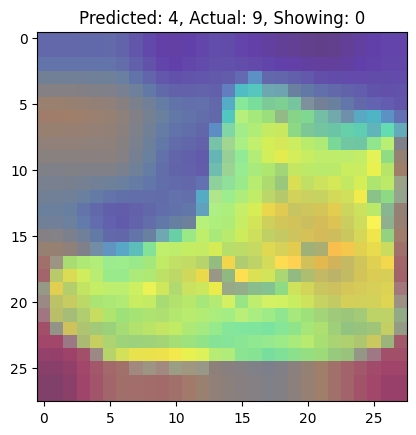

In [18]:
# Plot CAM for a random image from the dataset before training
img, label = train_dataset[0]
plot_cam(model, img, label, target=0)

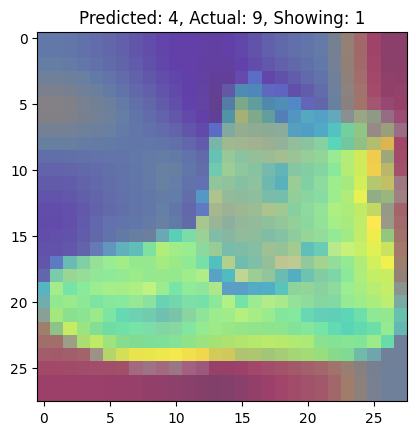

In [19]:
plot_cam(model, img, label, target=1)

In [20]:
# Training Loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
  for i, (images,labels) in enumerate(train_loader):
    outputs = model(images)
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 10/10 [04:54<00:00, 29.41s/it]


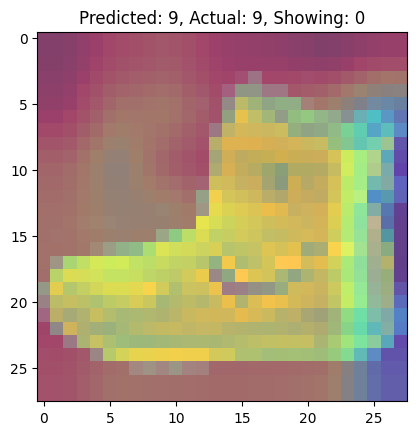

In [22]:
# Plot CAM for a random image from the dataset after training
img, label = train_dataset[0]
plot_cam(model, img, label, target=0)

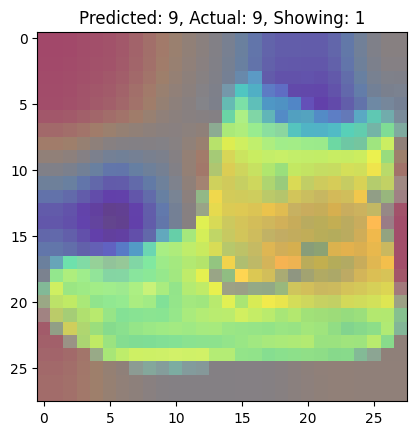

In [23]:
plot_cam(model, img, label, target=1)